<a href="https://colab.research.google.com/github/krademaker/VAE/blob/main/assignment_4a_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4a - Variational Auto-Encoders
## Deep Learning Course - Vrije Universiteit Amsterdam, 2022
#### Daniel Versluis (dvs243), Koen Rademaker (krr460) en Janneke Hulsen (vhn870)

#### Instructions on how to use this notebook:

This notebook is hosted on Google Colab. To be able to work on it, you have to create your own copy. Go to *File* and select *Save a copy in Drive*.

You can also avoid using Colab entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

The advantage of using Colab is that you can use a GPU. You can complete this assignment with a CPU, but it will take a bit longer. Furthermore, we encourage you to train using the GPU not only for faster training, but also to get experience with this setting. This includes moving models and tensors to the GPU and back. This experience is very valuable because for various models and large datasets (like large CNNs for ImageNet, or Transformer models trained on Wikipedia), training on GPU is the only feasible way.

The default Colab runtime does not have a GPU. To change this, go to *Runtime - Change runtime type*, and select *GPU* as the hardware accelerator. The GPU that you get changes according to what resources are available at the time, and its memory can go from a 5GB, to around 18GB if you are lucky. If you are curious, you can run the following in a code cell to check:

```sh
!nvidia-smi
```

Note that despite the name, Google Colab does  not support collaborative work without issues. When two or more people edit the notebook concurrently, only one version will be saved. You can choose to do group programming with one person sharing the screen with the others, or make multiple copies of the notebook to work concurrently.

**Submission:** Upload your notebook in .ipynb format to Canvas. The code and answers to the questions in the notebook are sufficient, no separate report is expected. 

In [ ]:
!nvidia-smi

Tue Dec 20 16:33:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Introduction

In this assignment, we are going to implement a Variational Auto-Encoder (VAE). A VAE is a likelihood-based deep generative model that consists of a stochastic encoder (a variational posterior over latent variables), a stochastic decoder, and a marginal distribution over latent variables (a.k.a. a prior). The model was originally proposed in two concurrent papers:
- [Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.](https://arxiv.org/abs/1312.6114)
- [Rezende, Danilo Jimenez, Shakir Mohamed, and Daan Wierstra. "Stochastic backpropagation and approximate inference in deep generative models." International conference on machine learning. PMLR, 2014.](https://proceedings.mlr.press/v32/rezende14.html)

You can read more about VAEs in Chapter 4 of the following book:
- [Tomczak, J.M., "Deep Generative Modeling", Springer, 2022](https://link.springer.com/book/10.1007/978-3-030-93158-2)

In particular, the goals of this assignment are the following:

- Understand how VAEs are formulated
- Implement components of VAEs using PyTorch
- Train and evaluate a model for image data

### Theory behind VAEs

VAEs are latent variable models trained with variational inference. In general, the latent variable models define the following generative process:
\begin{align}
1.\ & \mathbf{z} \sim p_{\lambda}(\mathbf{z}) \\
2.\ & \mathbf{x} \sim p_{\theta}(\mathbf{x}|\mathbf{z})
\end{align}

In plain words, we assume that for observable data $\mathbf{x}$, there are some latent (hidden) factors $\mathbf{z}$. Then, the training objective is log-likelihood function of the following form:
$$
\log p_{\vartheta}(\mathbf{x})=\log \int p_\theta(\mathbf{x} \mid \mathbf{z}) p_\lambda(\mathbf{z}) \mathrm{d} \mathbf{z} .
$$

The problem here is the intractability of the integral if the dependencies between random variables $\mathbf{x}$ and $\mathbf{z}$ are non-linear and/or the distributions are non-Gaussian.

By introducing variational posteriors $q_{\phi}(\mathbf{z}|\mathbf{x})$, we get the following lower bound (the Evidence Lower Bound, ELBO):
$$
\log p_{\vartheta}(\mathbf{x}) \geq \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z} \mid \mathbf{x})}\left[\log p_\theta(\mathbf{x} \mid \mathbf{z})\right]-\mathrm{KL}\left(q_\phi(\mathbf{z} \mid \mathbf{x}) \| p_\lambda(\mathbf{z})\right) .
$$

Note that we want to *maximize* this objective, therefore, in the code you are going to have to implement NELBO (negative ELBO) as a loss function (i.e., a minimization task). 

## IMPORTS

In [ ]:
# DO NOT REMOVE!
import os

import numpy as np
import matplotlib.pyplot as plt

import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import MNIST

In [ ]:
# Check if GPU is available and determine the device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(f'The available device is {device}')

The available device is cuda


In [ ]:
# mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
images_dir = '/content/gdrive/My Drive/Colab Notebooks/Results/'

## Auxiliary functions

Let us define some useful log-distributions:

In [ ]:
# DO NOT REMOVE
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5


def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

## Implementing VAEs

The goal of this assignment is to implement four classes:
- `Encoder`: this class implements the encoder (variational posterior), $q_{\phi}(\mathbf{z}|\mathbf{x})$.
- `Decoder`: this class implements the decoded (the conditional likelihood), $p_{\theta}(\mathbf{x}|\mathbf{z})$.
- `Prior`: this class implements the marginal over latents (the prior), $p_{\lambda}(\mathbf{z})$.
- `VAE`: this class combines all components.

#### Question 0: (3 pt) 
**Fully-connected Neural Networks (MLPs) or Convolutional Neural Networks**

This is not a real question but rather a comment. You are asked to implement your VAE using fully connected neural networks (MLPs) or convolutional neural networks (ConvNets). 

There is a difference in grading of this assignment based on your decision:
- **If you decide to implement your VAE with MLPs and the model works properly, you get 1 pt.**
- **If you decide to implement your VAE with ConvNets and the model works properly, you get 3 pts.**

### Encoder
We start with `Encoder`. Please remember that we assume the Gaussian variational posterior with a diagonal covariance matrix.

Feel free to add other methods to the class as well as arguments to the class initialization.

COMMENT or the code presented in this assignment, we refer to the code in chapter 4.3.5 of Deep Generative Modelling by Tomczak (2021). 
[Tomczak, J.M., "Deep Generative Modeling", Springer, 2022](https://link.springer.com/book/10.1007/978-3-030-93158-2)

In [ ]:
# YOUR CODE GOES HERE
# NOTE: The class must containt the following functions: 
# (i) reparameterization
# (ii) sample
# Moreover, forward must return the log-probability of variational posterior for given x, i.e., log q(z|x)

class Encoder(nn.Module):
    def __init__(self, encoder_net):
        # The init of the encoder network.
        super(Encoder, self).__init__()
        self.encoder = encoder_net
        
    # The reparameterization trick for Gaussians.
    @staticmethod
    def reparameterization(mu, log_var):
        # The formula is the following: # z = mu + std ∗ epsilon
        # epsilon ~ Normal(0,1)
        
        # First, we need to get std from log−variance.
        std = torch.exp(0.5*log_var)
        
        # Second, we sample epsilon from Normal(0,1).
        eps = torch.randn_like(std)
        
        # The final output
        return mu + std * eps
    
    # This function implements the output of the encoder network (i.e., parameters of a Gaussian).
    def encode(self, x):
        # First, we calculate the output of the encoder network of size 2M.
        h_e = self.encoder(x)
        # Second, we must divide the output to the mean and the log−variance.
        mu_e, log_var_e = torch.chunk(h_e, 2, dim=1) # TODO error
        return mu_e , log_var_e
    
    # Sampling procedure.
    def sample(self, x=None, mu_e=None, log_var_e=None):
        """
        Sample from the encoder. 
        If x is given (not equal to None), then copmute variational posterior distribution q(z|x) and sample from it.
        Otherwise, use `mu_e` and `log_var_e` as parameter of the variational posterior and sample from it.

        x: torch.tensor, with dimensionality (mini-batch, x_dim)
             a mini-batch of data points
        mu_e: torch.tensor, with dimensionality (mini-batch, x_dim)
             mean vector of the variational posterior
        log_var_e: torch.tensor, with dimensionality (mini-batch, x_dim)
             log variance of the variational posterior
        return: z: torch.tensor, with dimensionality (mini-batch, z_dim)
        """
        #If we don’t provide a mean and a log−variance, we must first calculate it:
        if (mu_e is None) and (log_var_e is None):
            mu_e , log_var_e = self.encode(x)
        # Or the final sample
        else:
        # Otherwise, we can simply apply the reparameterization trick!
            if (mu_e is None) or (log_var_e is None):
                raise ValueError('mu and log_var cannot be None')
        z = self.reparameterization(mu_e, log_var_e)
        return z
    
    # This function calculates the log−probability that is later used for calculating the ELBO.
    # log q(z|x)
    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        # If we provide x alone, then we can calculate a corresponding sample.
        if x is not None:
            mu_e, log_var_e = self.encode(x)
            z = self.sample(mu_e=mu_e, log_var_e=log_var_e)
        else:
        # Otherwise, we should provide mu, log−var and z.
            if (mu_e is None) or (log_var_e is None) or (z is None):
                raise ValueError('mu, log_var and z cannot be None')
        return log_normal_diag(z, mu_e, log_var_e)
    
    # PyTorch forward pass: it is either log−probability (by default) or sampling.
    def forward(self, x, type = "log_prob"):
        """
        Compute log-probability of variational posterior for given x, i.e., log q(z|x)
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
             a mini-batch of data points
        """
        assert type in ["encode", "log_prob"], 'Type can be either encode or log_prob'
        if type == "log_prob":
            return self.log_prob(x)
        else:
            return self.sample(x)

Please answer the following questions:


#### Question 1 (0.5 pt)

Please explain the reparameterization trick and provide a mathematical formula.

ANSWER:

VAEs learn to predict the mean $\mu$ and the standard deviation $\sigma$ of a Gaussian distribution to generate sample $z$ from a parameterized distribution. The decoder then decodes sample $z$. However, this sampling operation is not differentiable. Additionally, if we use sample $z$ from $q\phi(z|x)$ for the ELBO and calculate gradients to update the parameters of a neural network, there may be a large variance of the gradient. The reparameterization trick solves this. The essence of this trick is to move the stochasticity to independent random variables by reparameterizing the Gaussian distribution. The predictions are separated from the stochastic sampling element.

For a Gaussian distribution, the noise is considered a standard normal distribution: as a Gaussian with mean 0 and variance 1. Given Gaussian random variable $z$ with mean $\mu$ and variance $\sigma^2$, and independent random variable $\epsilon \sim 𝒩(\epsilon | 0,1)$, then the following holds:

$z = \mu + \sigma \cdotp \epsilon$.

Here, we use a fixed source of noise $\epsilon$ where we can sample from. When sampling $\epsilon$ from the standard Gaussian and applying the transformation from above, we obtain a sample from $𝒩 (z|\mu, \sigma)$.

The noise term is no longer parameterized by the model. In this way, the gradient is calculated with respect to a deterministic function instead of a stochastic element. The gradient path goes through a non-stochastic node. Hence, the sampling operation is made differentiable without large variance.

#### Question 2 (0.25 pt)

Please write down mathematically the log-probability of the encoder (variational posterior).

ANSWER:

The log-probability of the encoder/variational posterior is:

$\log q_\phi(z|x)$ 

For the variational posterior, $z$ is sampled from a multivariate Gaussian with mean $\mu_\phi$ and a diagonal covariance matrix $\sigma_\phi^2$:

$q_\phi(z|x) = 𝒩(z|\mu_\phi(x), \mathrm{diag}[\sigma^2_\phi(x)])$

where $\mu_\phi(x)$ and $\sigma^2_\phi(x)$ are given by a neural network.

### Decoder

The decoder is the conditional likelihood, i.e., $p(\mathbf{x}|\mathbf{z})$. Please remember that we must decide on the form of the distribution (e.g., Bernoulli, Gaussian, Categorical). Please discuss it with a TA or a lecturer if you are in doubt.

In [ ]:
# YOUR CODE GOES HERE
# NOTE: The class must containt the following function: 
# (i) sample
# Moreover, forward must return the log-probability of the conditional likelihood function for given z, i.e., log p(x|z)

class Decoder(nn.Module):
    def __init__(self, decoder_net, distribution = "categorical", num_vals = None):
        super(Decoder, self).__init__()

        # The decoder network.
        self.decoder = decoder_net
        # The distribution used for the decoder, categorical by default.
        self.distribution = distribution
        # The number of possible values. This is important for the categorical distribution.
        self.num_vals = num_vals

    # This function calculates parameters of the likelihood function p(x|z).
    def decode(self, z):
        # First, we apply the decoder network.
        h_d = self.decoder(z)

        # In this example, we use only the categorical distribution...
        if self.distribution == "categorical":
        # We save the shapes: batch size.
            b = h_d.shape[0]
        # and the dimensionality of x.
            d = h_d.shape[1]//self.num_vals
        # Then we reshape to (Batch size, Dimensionality, Number of Values).
            h_d = h_d.view(b , d, self.num_vals)
        # To get probabilities, we apply softmax.
            mu_d = torch.softmax(h_d, 2)
            return [mu_d]

        elif self.distribution == "bernoulli":
        # In the Bernoulli case, we have x_d \in {0,1}.
        # Therefore, it is enough to output a single probability, because
        # p(x_d=1|z) = \theta and p(x_d=0|z)=1-\theta.
            mu_d = torch.sigmoid(h_d)
            return [mu_d]
        
        else:
            raise ValueError("Only distribution options are categorical and bernoulli")

    # This function implements sampling from the decoder.
    def sample(self, z):
        """
        For a given latent code compute parameters of the conditional likelihood 
        and sample x ~ p(x|z)

        z: torch.tensor, with dimensionality (mini-batch, z_dim)

        return:
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
        """
        outs = self.decode(z)

        if self.distribution == "categorical":
            # We take the output of the decoder, shape = (b, d, self.num_vals)
            mu_d = outs[0]
            # and save shapes (we will need that for reshaping).
            b = mu_d.shape[0]
            m = mu_d.shape[1]
            # Here we use reshaping.
        
            # Daniel: This reshape is unnecessary? 
            mu_d = mu_d.view(mu_d.shape[0], -1, self.num_vals)

            # flatten first two dimensions 
            p = mu_d.view(-1, self.num_vals)
            
            # Eventually, we sample from the categorical (the built-in PyTorch function).
            # This generates a prediction for every pixel. Immediately reshape to (b,m,1)
            x_new = torch.multinomial(p, num_samples =  1).view(b,m)
        
        elif self.distribution == "bernoulli":
          # In the case of Bernoulli, we don't need any reshaping
            mu_d = outs[0]
          # and we can use the built-in PyTorch sampler.
            x_new = torch.bernoulli(mu_d)
        
        else:
            raise ValueError("Only distribution options are categorical and bernoulli")
        
        return x_new

    def log_prob(self, x, z):
        outs = self.decode(z)

        if self.distribution == "categorical":
            mu_d = outs[0]
            # log likelihood from probabilities mu_d
            log_p = log_categorical(x, mu_d, num_classes = self.num_vals,
                                    reduction = "sum", dim = -1).sum(-1)
        
        elif self.distribution == "bernoulli":
            mu_d = outs[0]
            log_p = log_bernoulli(x, mu_d, reduction = "sum", dim = -1)

        else:
            raise ValueError("Only distribution options are categorical and bernoulli")

        return log_p

    # The forward pass is either a log-prob or a sample.
    def forward(self, z, x=None, type="log_prob"):
        """
        Compute the log probability: log p(x|z). 
        z: torch.tensor, with dimensionality (mini-batch, z_dim)
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
        """
        assert type in ["decoder", "log_prob"], "Type can be either decode or log_prob"

        if type == "log_prob":
            # calculate the log likelihood log p(x|z)
            return self.log_prob(x, z)
        else:
            # generate an image x^hat
            return self.sample(x)

Please answer the following questions:

#### Question 3 (0.5 pt)

Please explain your choice of the distribution for image data used in this assignment. Additionally, please write it down mathematically (if you think that presenting it as the log-probability, then please do it).

ANSWER:

The MNIST dataset contains 8-bit encoded images, where every pixel has a discrete value from $0$ to $255$. To put this in mathematical notation, an image is represented as $x$ with $x= \mathcal{X}^D \in \{0, 1, \ldots, 255\}$, $D$ being the dimensionality of the image.

Since we are dealing with discrete variables, it makes sense to model the probabilities of all discrete pixel values per pixel with a $\textbf{categorical}$, or formally a multinomial probability distribution. This multinomial distribution $\theta(\mathbf{z})$ depends on the $\mathbf{z}$ we sampled (see answer to Question 4 for the method of sampling).

How we go from $\mathbf{z})$ to probability values for all pixel values is parameterized by a neural network with a softmax at the end: $\theta(\mathbf{z}) =$ softmax(NN($\mathbf{z}$)).

Given $\theta(\mathbf{z})$, we can compute the log likelihood of $\mathbf{x}$: $p_{\theta}(\mathbf{x}|z) $. For a multi-dimensional image vector $\mathbf{x}$, this entails summing the log probability of all true pixel values in the original image.

$\log p_{\theta}(\mathbf{x}|\mathbf{z}) = \sum^D_d \log p_\theta(x_{d,\text{true}}|\mathbf{z}) $
This can be seen in the $\texttt{log_categorical()}$ function.

Alternatively, if the in put of every pixel is binary (black-white) such that $x= \mathcal{X}^D \in \{0, 1\}$, the discrete probability values for all pixel values $x_d$ can be given by a Bernoulli distribution.

#### Question 4 (0.5 pt)

Please explain how one can sample from the distribution chosen by you. Please be specific and formal (i.e., provide mathematical formulae). If applicable, please provide a code snippet.

ANSWER:

The encoder network outputs $M$ values for the mean $\mu_{\phi}$ and $M$ values for the log variance $\log \sigma^2_{\phi}$. The variance is in log form so that negative and zero values outputted by the network can still be converted to valid values for $\sigma^2$ by taking $\exp(\log \sigma^2)$. The means and variances are represented by vectors $\boldsymbol{\mu}_{\theta}$, $\boldsymbol{\sigma^2}_{\theta} \in \mathbb{R}^{M}.$

We now sample $\mathbf{z} \sim  q_{\phi}(\mathbf{z}|\mathbf{x})$ using the reparametrization trick:
$\mathbf{z} = \boldsymbol{\mu}_{\theta} + \boldsymbol{\sigma^2}_{\theta} \odot \boldsymbol{\epsilon}$, $\odot$ denoting elementwise multiplication. $\boldsymbol{\epsilon}$ is sampled from a standard multivariate Gaussian: $\boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$.

Sampling $\mathbf{z}$ in this manner returns $\mathbf{z} \sim \mathcal{N}(\mathbf{z} |\boldsymbol{\mu}_{\theta}, \boldsymbol{\sigma^2}\mathbf{I})$.

To go from our sampled $\mathbf{z}$ to generated image, we feed $\mathbf{z}$ to the decoder net, obtaining probabilities for all discrete pixel values $\{0, 1, 2, \ldots, 255\}$ for all pixels. Using these probabilities, for every pixel the corresponding multinomial distribution is sampled to obtain a pixel value. The sampled pixdel values can then be compiled to obtain a generated image.

### Prior

The prior is the marginal distribution over latent variables, i.e., $p(\mathbf{z})$. It plays a crucial role in the generative process and also in synthesizing images of a better quality.

In this assignment, you are asked to implement a prior that is learnable (e.g., parameterized by neural networks). If you decide to implement the standard Gaussian prior only, then please be aware that you will not get any points.


For the learnable prior you can choose one of the following options:


*   Mixture of Gaussians
*   Normalizing Flow


In [ ]:
# YOUR CODE GOES HERE
# NOTES:
# (i) Implementing the standard Gaussian prior does not give you any points!
# (ii) The function "sample" must be implemented.
# (iii) The function "forward" must return the log-probability, i.e., log p(z)

class Prior(nn.Module):
    def __init__(self, L, device='cpu'): # deviation, the github code does not have device parameter
        super(Prior, self).__init__()
        self.device = 'cuda'
        self.L = L

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def forward(self, z):
        return log_standard_normal(z)
    
    def log_prob(self, z):
        return log_standard_normal(z)

#### Question 5 (2 pts max)

**Option 1 (0 pt):  Standard Gaussian**

**NOTE: *If you decide to use the standard Gaussian prior, please indicate it in your answer. However, you will get 0 pt for this question.***

**Option 2 (0.5 pt): Mixture of Gaussains**

Please do the following:
- (0.25 pt) Please explain your prior and write it down mathematically
- (0.15 pt) Please write down its sampling procedure (if necessary, please add a code snippet).
- (0.1 pt) Please write down its log-probability (a mathematical formula).

**Option 3 (2 pts): Normalizing Flow**

Please do the following:
- (1 pt) Please explain your prior and write it down mathematically
- (0.5 pt) Please write down its sampling procedure (if necessary, please add a code snippet).
- (0.5 pt) Please write down its log-probability (a mathematical formula).

ANSWER We opted for the standard Gaussian prior. 

### Complete VAE

The last class is `VAE` tha combines all components. Please remember that this class must implement the **Negative ELBO** in `forward`, as well as `sample` (*hint*: it is a composition of `sample` functions from the prior and the decoder).

In [ ]:
# YOUR CODE GOES HERE
# This class combines Encoder, Decoder and Prior.
# NOTES:
# (i) The function "sample" must be implemented.
# (ii) The function "forward" must return the negative ELBO. Please remember to add an argument "reduction" that is either "mean" or "sum".
class VAE(nn.Module):
    def __init__(self, encoder_net, decoder_net, num_vals = 256,
                 L = 16, likelihood_type = "categorical", device='cpu'): # here again, 'device' is new parameter
        super(VAE, self).__init__()

        self.encoder = Encoder(encoder_net=encoder_net).to(device)
        self.decoder = Decoder(distribution=likelihood_type, decoder_net=decoder_net,
                               num_vals=num_vals).to(device)
        self.prior = Prior(L = L).to(device)

        self.num_vals = num_vals

        self.likelihood_type = likelihood_type

    def sample(self, batch_size=64):
        z = self.prior.sample(batch_size=batch_size).to(device)
        return self.decoder.sample(z)

    def forward(self, x, reduction='mean'):
        # encoder
        mu_e, log_var_e, = self.encoder.encode(x) # TODO error
        z = self.encoder.sample(mu_e = mu_e, log_var_e=log_var_e)
        
        # Negative ELBO (NELBO)
        #NELBO = 0.
        RE = self.decoder.log_prob(x, z)
        KL = (self.prior.forward(z) - self.encoder.log_prob(mu_e = mu_e,
                                                             log_var_e = log_var_e,
                                                             z=z)).sum(-1)
        NELBO = -(RE + KL)

        if reduction == 'sum':
            return NELBO.sum()
        else:
            return NELBO.mean()

COMMMENT: We opted for a convolutional encoder network and a MLP decoder network. The linear network had a hidden layer size of $2*256 = 512$, while the number of latent variables $z$ ($L$) was set to $150$. 

In [ ]:
likelihood_type = 'categorical'
D = 784
M = 256*2
L = 150

if likelihood_type == 'categorical':
    num_vals = 256
elif likelihood_type == 'bernoulli':
    num_vals = 1


# convolutional encoder
encoder = nn.Sequential(nn.Unflatten(1, (1, 28, 28)),
                        nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = 1),
                        nn.ReLU(), # size: batch, 1, 28, 28, 
                        nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
                        nn.ReLU(), 
                        nn.Flatten(1),
                        nn.Linear(32*28*28, 2 * L))

encoder.to(device)
decoder = nn.Sequential(nn.Linear(L, M),
                        nn.LeakyReLU(),
                        nn.Linear(M, M),
                        nn.LeakyReLU(),
                        nn.Linear(M, num_vals * D))
decoder.to(device)

Sequential(
  (0): Linear(in_features=150, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=512, out_features=200704, bias=True)
)

#### Question 6 (0.5 pt)

Please write down mathematically the **Negative ELBO** and provide a code snippet.

ANSWER: 

We fill in the negative ELBO of the form: $-ELBO = -(RE + KL)$, where **reconstruction errror** $RE = \ln p_{\theta}(\mathbf{x} | \mathbf{z})$, and **Kullback-Leibler divergence** $KL = \left[ \ln q_{\phi}(\mathbf{z}|\mathbf{x}) -  \ln p(\mathbf{z}) \right]$.

As given in Question 3, we use a categorical distribution for our decoder $p_{\theta}(\mathbf{x} | \mathbf{z}) = \mathrm{Categorical} \left( \mathbf{x}|\theta(\mathbf{z}) \right)$, and as given in Question 5, we use a standard Gaussian prior $p(\mathbf{z}) = \mathcal{N}\left(\mathbf{z}_{\phi} | 0, \mathbf{I} \right)$.

This gives us the following: $-ELBO(\theta, \phi) = - \left\{ \ln \mathrm{Categorical} \left( \mathbf{x}|\theta \left( 
\mathbf{z}_{\phi} \right) \right) + \left[ \ln \mathcal{N}\left( \mathbf{z}_{\phi} | \mu_{\phi}(\mathbf{x}), \sigma_{\phi}^2(\mathbf{x}) \right) + \ln \mathcal{N}\left( \mathbf{z}_{\phi} | 0, \mathbf{I} \right) \right] \right\}$

Code snippet for Negative ELBO: 
```
# Negative ELBO (NELBO)
#NELBO = 0.
RE = self.decoder.log_prob(x, z)
KL = (self.prior.forward(z) - self.encoder.log_prob(mu_e = mu_e,
                                                    log_var_e = log_var_e,
                                                    z=z)).sum(-1)
        NELBO = -(RE + KL)
```

### Evaluation and training functions

**Please do not remove or modify them.**

In [ ]:
# DO NOT REMOVE

def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, (test_batch, _) in enumerate(test_loader):
        test_batch = test_batch.to(device)
        b = test_batch.shape[0]
        test_batch = torch.reshape(test_batch, (b, 28*28))
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader, shape=(28,28)):
    # real images-------
    num_x = 4
    num_y = 4
    x, _ = next(iter(test_loader))
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, shape=(28,28), extra_name=''):
    x, _ = next(iter(data_loader))
    x = x.to('cpu').detach().numpy()

    # generations-------
    model_best = torch.load(name + '.model')
    model_best.to(device)
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [ ]:
# DO NOT REMOVE

def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, shape=(28,28)):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, (batch, _) in enumerate(training_loader):
            b = batch.shape[0]
            batch = torch.reshape(batch, (b, 28*28))
            batch = batch.to(device)
            loss = model.forward(batch, reduction='mean')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(f'{indx_batch}/{50000/batch_size}', end = '\r')
        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, shape=shape, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### Setup

**NOTE: *Please comment your code! Especially if you introduce any new variables (e.g., hyperparameters).***

In the following cells, we define `transforms` for the dataset. Next, we initialize the data, a directory for results and some fixed hyperparameters.

In [ ]:
# PLEASE DEFINE APPROPRIATE TRANFORMS FOR THE DATASET
transforms_train = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

transforms_test = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

Please do not modify the code in the next cell.

In [ ]:
# DO NOT REMOVE
#-dataset
dataset = MNIST('/files/', train=True, download=True,
                      transform=transforms_train
                )

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000], generator=torch.Generator().manual_seed(14))

test_dataset = MNIST('/files/', train=False, download=True,
                      transform=transforms_test
                     )
#-dataloaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#-creating a dir for saving results
name = 'vae'
result_dir = images_dir + 'results/' + name + '/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

#-hyperparams (please do not modify them for the final report)
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In the next cell, please initialize the model. Please remember about commenting your code!

In [ ]:
# YOUR CODE COMES HERE:
prior = torch.distributions.MultivariateNormal(torch.zeros(L), torch.eye(L)) # Standard Gaussian prior
model = VAE(encoder_net=encoder, decoder_net=decoder, num_vals=num_vals, L=L, likelihood_type=likelihood_type)
model.to(device) # move model to GPU


VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(1, 28, 28))
      (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Flatten(start_dim=1, end_dim=-1)
      (6): Linear(in_features=25088, out_features=300, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=150, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=512, out_features=200704, bias=True)
    )
  )
  (prior): Prior()
)

Please initialize the optimizer

In [ ]:
# PLEASE DEFINE YOUR OPTIMIZER
lr = 0.002 # learning rate
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

#### Question 7 (0.5 pt)
Please explain the choice of the optimizer, and comment on the choice of the hyperparameters (e.g., the learing reate value).

ANSWER:

As an optimizer, we chose pytorch’s implementation of Adamax (Kingma and Ba, 2014). Adam (Adaptive Moment Estimation) is an optimizer that adaptively computes individual learning rates for each parameter. Adamax is a variant of Adam that is based on the infinity norm, aimed to accelarate the optimization process. Based on recommendations by Sebastian Ruder (Ruder, 2016), we used Adamax with the hyperparameters learning rate = 0.002, $β_1=0.9$, and $β_2=0.999$ and $\epsilon = 1e^{-8}$.
The value we chose for the learning rate will be tested and evaluated further on in question 9.
<br><br>
Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." *arXiv preprint arXiv:1412.6980* (2014).

Ruder, Sebastian. "An overview of gradient descent optimization algorithms." *arXiv preprint arXiv:1609.04747* (2016).

### Training and final evaluation

In the following two cells, we run the training and the final evaluation.

In [ ]:
lr = 0.002 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [ ]:
# DO NOT REMOVE OR MODIFY
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, 
                   num_epochs=num_epochs, model=model, optimizer=optimizer,
                   training_loader=train_loader, val_loader=val_loader,
                   shape=(28,28))

Epoch: 0, val nll=217.18701479492188
saved!
Epoch: 1, val nll=179.93992866210937
saved!
Epoch: 2, val nll=160.92179172363282
saved!
Epoch: 3, val nll=149.97623403320313
saved!
Epoch: 4, val nll=143.60857612304687
saved!
Epoch: 5, val nll=139.0380762451172
saved!
Epoch: 6, val nll=136.18403818359374
saved!
Epoch: 7, val nll=134.5958966064453
saved!
Epoch: 8, val nll=132.91612243652344
saved!
Epoch: 9, val nll=132.11680705566405
saved!
Epoch: 10, val nll=131.41546657714844
saved!
Epoch: 11, val nll=130.17499665527345
saved!
Epoch: 12, val nll=129.72082080078124
saved!
Epoch: 13, val nll=128.92853605957032
saved!
Epoch: 14, val nll=128.71549130859376
saved!
Epoch: 15, val nll=128.3280083984375
saved!
Epoch: 16, val nll=127.88661302490235
saved!
Epoch: 17, val nll=127.69106411132813
saved!
Epoch: 18, val nll=127.07447830810547
saved!
Epoch: 19, val nll=126.90703646240235
saved!
Epoch: 20, val nll=126.62087263183594
saved!
Epoch: 21, val nll=126.25121413574219
saved!
Epoch: 22, val nll=127.

In [ ]:
# DO NOT REMOVE OR MODIFY
# Final evaluation
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)
samples_generated(result_dir + name, test_loader, extra_name='_FINAL')

plot_curve(result_dir + name, nll_val)

FINAL LOSS: nll=124.11113305664063


### Results and discussion

After a successful training of your model, we would like to ask you to present your data and analyze it. Please answer the following questions.


#### Question 8 (1 pt)

Please select the real data, and the final generated data and include them in this report. Please comment on the following:
- (0.5 pt) Do you think the model was trained properly by looking at the generations? Please motivate your answer well.
- (0.5 pt) What are potential problems with evaluating a generative model by looking at generated data? How can we evalute generative models (ELBO or NLL do not count as an answer)?

This image shows some of the real images from the MNIST dataset.

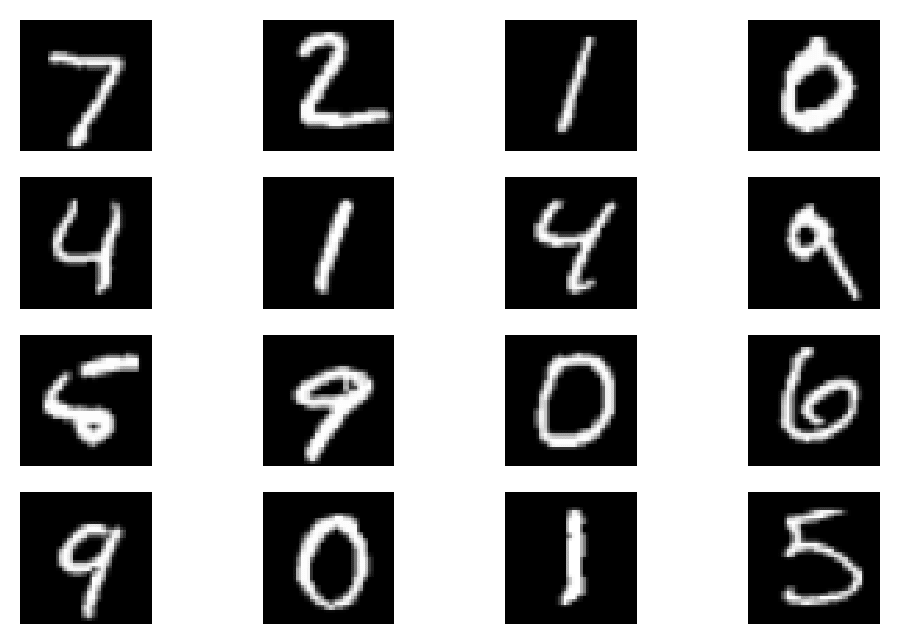

The image below shows eight images generated by the trained VAE. 

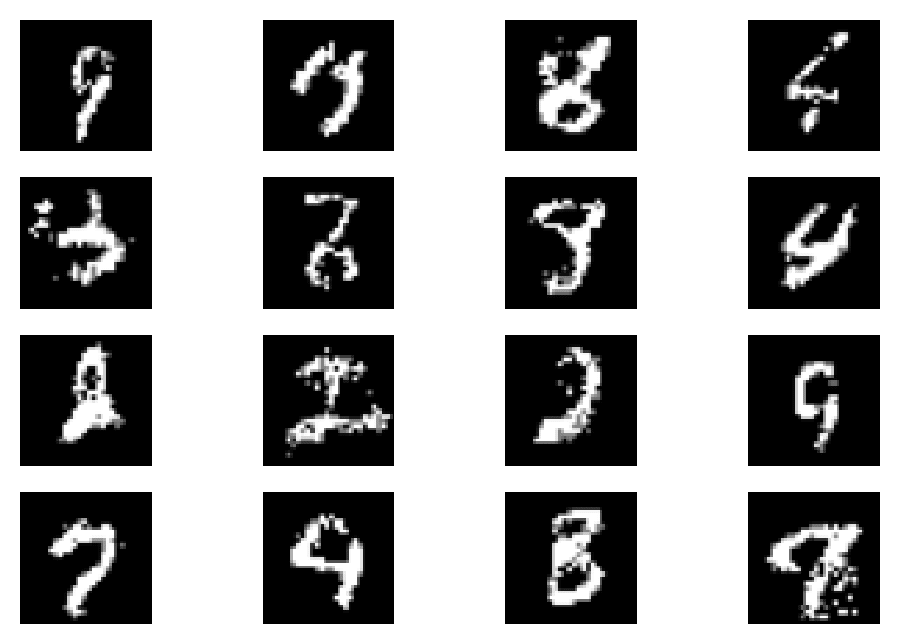

ANSWER:

The first image shown above are real images from the MNIST dataset, while the second image shows images generated by the trained VAE. Most of the generations produced by our model contain a discernable number and resemble the MNIST images used as input. Therefore, we believe the model was trained properly. Previous attempts where fewer latent variables were used produced unrecognizable data with only a few white spots at seemingly random positions. The quality of the generated images can probably be increased by further increasing the number of latent variables used. 

Potential problems with evaluating a generative model by looking at generated data are that since this is a qualitative way of assessing the results, it is subjective and affected by biases (Borji, 2019). It’s also dependent on the knowledge of the evaluator about what is realistic to expect. Since someone else may have a different opinion about the model’s success, this way of evaluation is not reproducible. Another problem is that there are a lot of images for which it would take a lot of time to look at them all.

Two alternative ways of evaluating generative models are (1) nearest neighbor analysis or (2) classification by a pre-trained network. The Nearest Neighbors approach involves selection of real images that are in the same domain or of the same object. For our MNIST dataset, this would be images of the same number. These images are used for comparison. The difference or similarity between the images can be calculated with distance measures like Euclidean distance between pixel data. Another method could be to use a pre-trained neural network to classify the images generated by the generative model (Salimans et al., 2016). For each generated image, the classification model assigns the probability of belonging to each class. Summarizing these probabilities gives a score that can be used for evaluation.

<br><br>
Borji, Ali. "Pros and cons of gan evaluation measures." *Computer Vision and Image Understanding* 179 (2019): 41-65.

Salimans, Tim, Ian Goodfellow, Wojciech Zaremba, Vicki Cheung, Alec Radford, and Xi Chen. "Improved techniques for training gans." *Advances in neural information processing systems* 29 (2016).

In [ ]:
# Hyperparameter tuning
num_epochs = 20
max_patience = 10
batch_size = 64

prior = torch.distributions.MultivariateNormal(torch.zeros(L), torch.eye(L))
model = VAE(encoder_net=encoder, decoder_net=decoder, num_vals=num_vals, L=L, likelihood_type=likelihood_type)
model.to(device)

for optim in ['SGD', 'Adamax']: 
    for lr in [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01]: 
        name = f'training_optimizer_{optim}_lr_{lr}'
        #-creating a dir for saving results
        result_dir = images_dir + 'results/' + name + '/'
        if not(os.path.exists(result_dir)):
            os.mkdir(result_dir)
        if optim == 'AdaMax':
            optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)
        if optim == 'SGD': 
            optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

        nll_val = training(name=result_dir + name, max_patience=max_patience, 
                        num_epochs=num_epochs, model=model, optimizer=optimizer,
                        training_loader=train_loader, val_loader=val_loader,
                        shape=(28,28))
        np.savetxt(result_dir + name, nll_val)




Epoch: 0, val nll=211.474072265625
saved!
Epoch: 1, val nll=177.39350480957032
saved!
Epoch: 2, val nll=158.80342431640625
saved!
Epoch: 3, val nll=147.85513823242187
saved!
Epoch: 4, val nll=142.31177722167968
saved!
Epoch: 5, val nll=138.5957794921875
saved!
Epoch: 6, val nll=136.16339249267577
saved!
Epoch: 7, val nll=134.08062443847658
saved!
Epoch: 8, val nll=132.81400705566406
saved!
Epoch: 9, val nll=131.54044733886718
saved!
Epoch: 10, val nll=131.34134565429687
saved!
Epoch: 11, val nll=129.8858255004883
saved!
Epoch: 12, val nll=129.2088252319336
saved!
Epoch: 13, val nll=128.60899020996095
saved!
Epoch: 14, val nll=128.38567412109376
saved!
Epoch: 15, val nll=128.08821359863282
saved!
Epoch: 16, val nll=127.66374587402343
saved!
Epoch: 17, val nll=127.37452087402343
saved!
Epoch: 18, val nll=126.9860470703125
saved!
Epoch: 19, val nll=127.10414552001953


#### Question 9 (1.25 pt)

Please include the plot of the negative ELBO. Please comment on the following:
- (0.25 pt) Is the training of your VAE stable or unstable? Why?
- (1 pt) What is the influence of the optimizer on your model? Do the hyperparameter values of the optimizer important and how do they influence the training? Motivate well your answer (e.g., run the script with more than one learning rate and present two plots here).

NB: Plot title, labels and ticks only clearly visible in white mode.


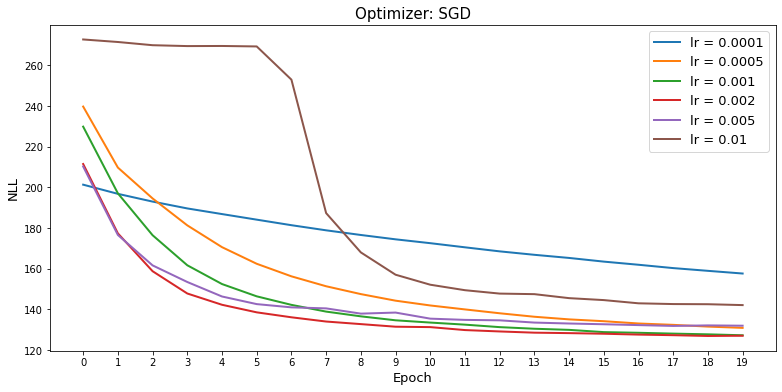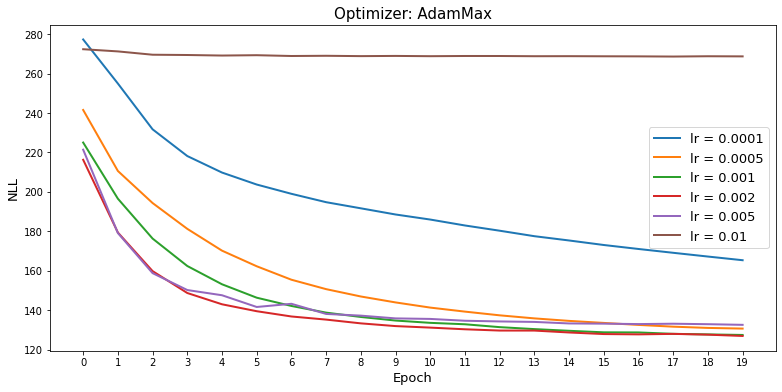



ANSWER: [Please fill in]

We evaluated our VAE with Adamax and learning rate 0.002, and observed stable training that clearly minimized negative log-likelihood (NLL) loss over the course of training epochs (see code in Question 7).

To further evaluate the influence of optimizers and learning rates, we compared VAE training with SGD or Adamax optimizers and various learning rates (0.01, 0.005, 0.002, 0.001, 0.0005 and 0.0001), each with 20 epochs. We found that particular learning rates could strongly impact model training. The highest learning rate (0.01) with SGD did not minimize NLL for several epochs, and with Adamax the NLL remained mostly constant over all 20 epochs. On the other hand, the lowest learning rate (0.0001) can be seen to minimize loss at a slower rate than other learning rates in SGD, and to minimize loss seemingly fast in the first epochs in Adamax to then also minimize at a slower rate. With a learning rate of 0.005 some stochastic behaviour on the loss can be observed for earlier epochs in both SGD and Adamax. We previously cited literature recommending a learning rate of 0.002 in Question 7. In our evaluations of SGD and Adamax, we too observe that this learning rate achieves the lowest loss, with the similar learning rate 0.001 following closely. Finally, we did not observe strong disparities between the SGD and Adamax optimizers.

# Grading (10pt)

- Question 0: 3pt
- Question 1: 0.5pt 
- Question 2: 0.25pt 
- Question 3: 0.5pt 
- Question 4: 0.5pt 
- Question 5: 2pt 
- Question 6: 0.5pt
- Question 7: 0.5pt
- Question 8: 1pt
- Question 9: 1.25pt